In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.coordinates import SkyCoord
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import multipole_map
import dipole

In [3]:
# fitting function
def fit_multipole(map_to_fit, template_maps, Cinv=None, fit_zeros=False, idx=None):
    """
    Fit multipole amplitudes to an input healpix density map.
    
    Parameters
    ----------
    map_to_fit : 1D array-like, length npix
        Input healpix map.
    template_maps : 2D array-like, shape (2 * ell + 1, npix)
        Template healpix maps, one for each multipole order m.
        Must be in order or increasing m! i.e. [-m,m]
    Cinv : array-like, optional
        Inverse covariance matrix. If 1D, taken to be the diagonal terms.
    fit_zeros : bool, optional
        Whether to fit zero-valued pixels in `map_to_fit`. The default is False.
    idx : array-like, optional
        Pixel indices to fit.
    
    Returns
    -------
    bestfit_pars :
        The 2 * ell + 1 best-fit amplitudes corresponding to each template map.
    bestfit_stderr :
        The standard error on the fit.
    
    """
    assert map_to_fit.ndim == 1, "input map must be 1-dimensional"
    assert len(map_to_fit) == template_maps.shape[1], "input map and template maps must have the same NPIX"
    
    NPIX = len(map_to_fit)
    # design matrix
    A = np.column_stack((np.ones(NPIX), template_maps.T))
    # covariances: identity for now
    if Cinv is None:
        Cinv = np.ones(NPIX)
    else:
        assert len(Cinv) == NPIX, "input Cinv and input map must have the same length"

    # indices to fit
    idx_to_fit = np.full(NPIX, True)
    if fit_zeros is False:
        idx_to_fit = idx_to_fit & (map_to_fit!=0.)
    if idx is not None:
        assert len(idx) == NPIX, "input idx and input map must have the same length"
        idx_to_fit = idx_to_fit & idx
    map_to_fit, A, Cinv = map_to_fit[idx_to_fit], A[idx_to_fit], Cinv[idx_to_fit]

    # perform the regression
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A, Cinv)

    # uncertainties on the best-fit pars
    bestfit_stderr = np.sqrt(np.diag(np.linalg.inv(bestfit_Cinv)))

    return bestfit_pars, bestfit_stderr

### inputs

In [4]:
NSIDE = 64

### load sample

In [5]:
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                      blim=30, maglim=16.4, load_init=False)
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=False, compcorrect=True)
d = SecrestDipole(**quaia_kwargs)
map_ = d.load_hpxelatcorr()

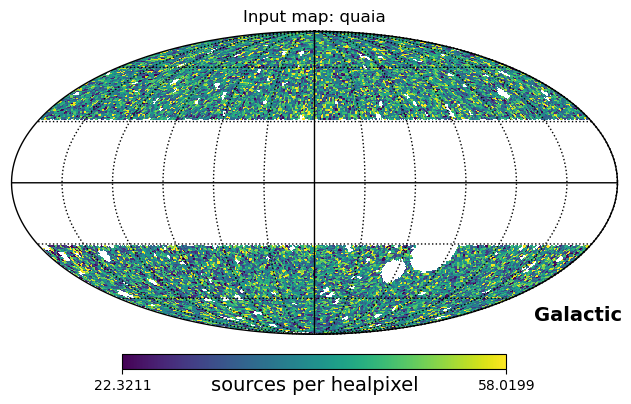

In [6]:
# construct map from source density table
map_to_fit = np.empty(hp.nside2npix(NSIDE))
map_to_fit[:] = np.nan
map_to_fit[map_['hpidx']] = map_['elatdenscorr']
mean, std = np.nanmean(map_to_fit), np.nanstd(map_to_fit)
fig = plt.figure(figsize=(8,4))
hp.mollview(map_to_fit, coord=['C','G'], title=f'Input map: {d.catname}', unit='sources per healpixel',
            badcolor='w', min=mean-2*std, max=mean+2*std, fig=fig)
hp.graticule()

### dipole
Check that old and new template maps & fitting functions give identical results!

Text(0.5, 0.98, 'Dipole templates (old function)')

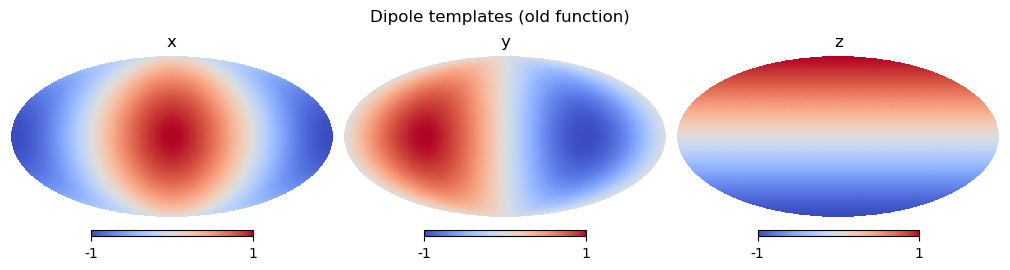

In [7]:
# maps as constructed in my dipole fitting functions
template_amps = np.column_stack((np.zeros(3), np.diag(np.ones(3)))) # first column for the monopole 
                                                                    #  since dipole_map() takes 4 input amplitudes
old_dipole_templates = np.array([
    dipole.dipole_map(amps, NSIDE=NSIDE) for amps in template_amps
])

fig = plt.figure(figsize=(10,2.5))
titles = ['x', 'y', 'z']
for i, template in enumerate(old_dipole_templates):
    hp.mollview(template, sub=(1,3,i+1), title=titles[i], min=-1, max=1, cmap='coolwarm', fig=fig)
fig.suptitle('Dipole templates (old function)')

Text(0.5, 0.98, 'Dipole templates (new function)')

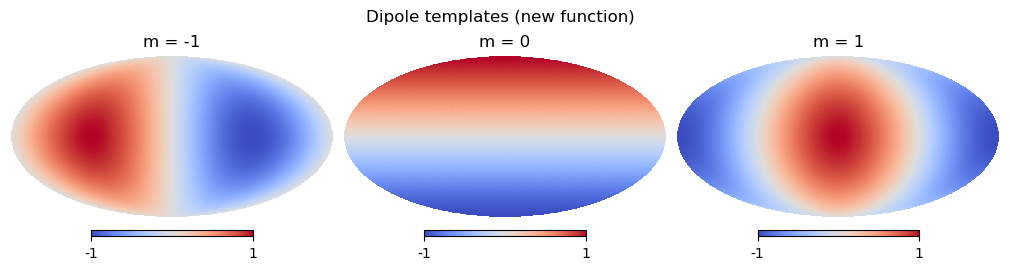

In [8]:
# my new template map construction
ampss = np.identity(3)
new_dipole_templates = np.array([
    multipole_map(amps, NSIDE=NSIDE) for amps in ampss
])  # multipole_map() assumes ell from len(amps) and assumes that amps are given in order of increasing m

fig = plt.figure(figsize=(10,2.5))
titles = ['m = -1', 'm = 0', 'm = 1']
for i, template in enumerate(new_dipole_templates):
    hp.mollview(template, sub=(1,3,i+1), title=titles[i], min=-1, max=1, cmap='coolwarm')
fig.suptitle('Dipole templates (new function)')

best-fit pars:  [40.1713338  -0.4498161  -0.28298122 -0.33171183]


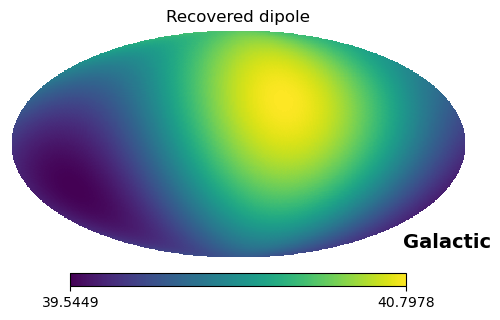

In [9]:
# old fitting function: this automatically fits the monopole + 3 dipole templates
pars, stderr = dipole.fit_dipole(map_to_fit, idx=~np.isnan(map_to_fit))
print("best-fit pars: ", pars)

# monopole + dipole
bestfit_dipmap = dipole.dipole_map(pars, NSIDE=NSIDE)
fig = plt.figure(figsize=(7,3))
hp.mollview(bestfit_dipmap, coord=['C','G'], title='Recovered dipole', fig=fig)

best-fit pars:  [40.1713338  -0.28296587 -0.33168484 -0.44979169]


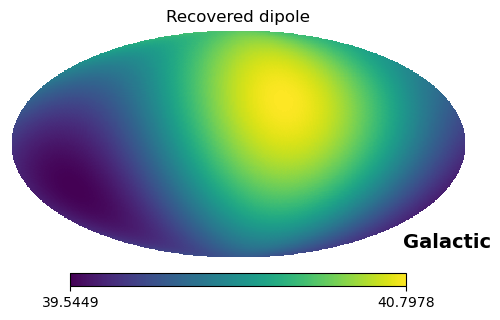

In [10]:
# new fitting function: automatically adds the monopole to the design matrix
pars, stderr = fit_multipole(map_to_fit, new_dipole_templates, idx=~np.isnan(map_to_fit))
print("best-fit pars: ", pars)

# monopole + dipole
bestfit_dipmap = multipole_map(pars[0], NSIDE=NSIDE) + multipole_map(pars[1:], NSIDE=NSIDE)
fig = plt.figure(figsize=(7,3))
hp.mollview(bestfit_dipmap, coord=['C','G'], title='Recovered dipole', fig=fig)

In [11]:
amp = np.linalg.norm(pars[1:]/pars[0])
# manually tell healpy which parameters correspond to the x, y, and z directions
direction = hp.vec2dir(pars[3], vy=pars[1], vz=pars[2])
direction = SkyCoord(direction[1], np.pi/2 - direction[0], frame='icrs', unit='rad')
amp, direction.galactic

(0.015593608750467131,
 <SkyCoord (Galactic): (l, b) in deg
     (321.47910533, 28.10264827)>)

Correct fiducial result!

### quadrupole

Text(0.5, 0.98, 'Quadrupole templates')

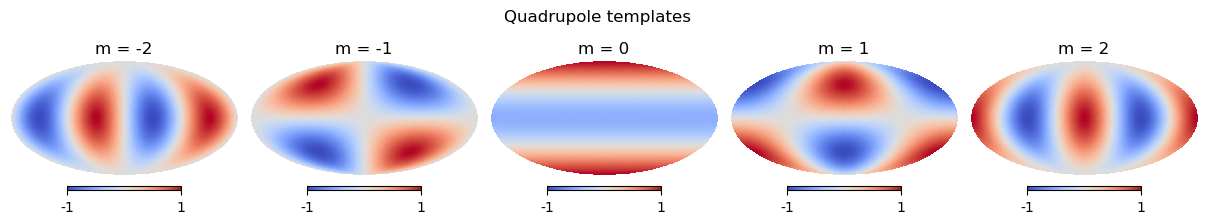

In [12]:
ampss = np.identity(5)
quadrupole_templates = np.array([
    multipole_map(amps, NSIDE=NSIDE) for amps in ampss
])

fig = plt.figure(figsize=(12,2))
titles = ['m = -2', 'm = -1', 'm = 0', 'm = 1', 'm = 2']
for i, template in enumerate(quadrupole_templates):
    hp.mollview(template, sub=(1,5,i+1), title=titles[i], min=-1, max=1, cmap='coolwarm', fig=fig)
fig.suptitle('Quadrupole templates')

best-fit pars:  [40.03400528  0.19199052  0.04091246 -0.19512012 -0.25763942  0.0560086 ]


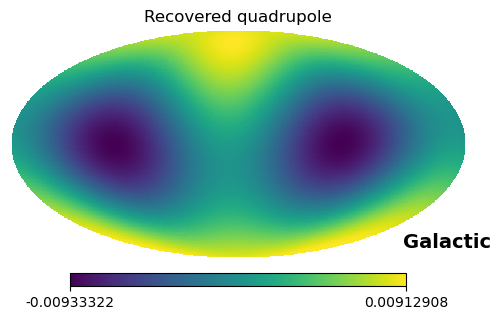

In [13]:
# fit to same map as above
pars, stderr = fit_multipole(map_to_fit, quadrupole_templates, idx=~np.isnan(map_to_fit))
print("best-fit pars: ", pars)

# quadrupole scaled by the monopole
bestfit_map = multipole_map(pars[1:], NSIDE=NSIDE) / pars[0]
fig = plt.figure(figsize=(7,3))
hp.mollview(bestfit_map, coord=['C','G'], title='Recovered quadrupole', fig=fig)

In [14]:
amp = np.linalg.norm(pars[1:]/pars[0])
amp

0.009548329618568462

### octupole

Text(0.5, 0.98, 'Octupole templates')

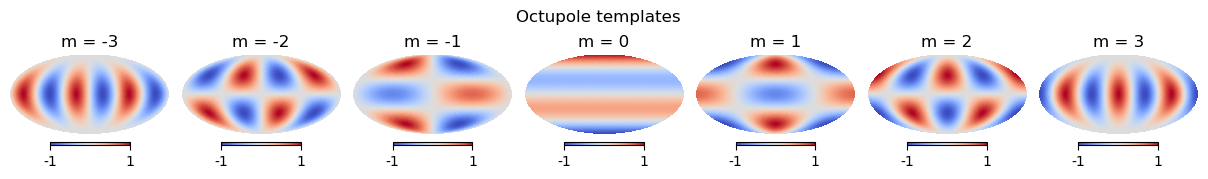

In [15]:
ampss = np.identity(7)
octupole_templates = np.array([
    multipole_map(amps, NSIDE=NSIDE) for amps in ampss
])

fig = plt.figure(figsize=(12,1.5))
titles = ['m = -3', 'm = -2', 'm = -1', 'm = 0', 'm = 1', 'm = 2', 'm = 3']
for i, template in enumerate(octupole_templates):
    hp.mollview(template, sub=(1,len(ampss),i+1), title=titles[i], min=-1, max=1, cmap='coolwarm', fig=fig)
fig.suptitle('Octupole templates')

best-fit pars:  [40.16499022 -0.11092106  0.06628344 -0.05219577  0.47952937  0.22129515
  0.1705965  -0.07657749]


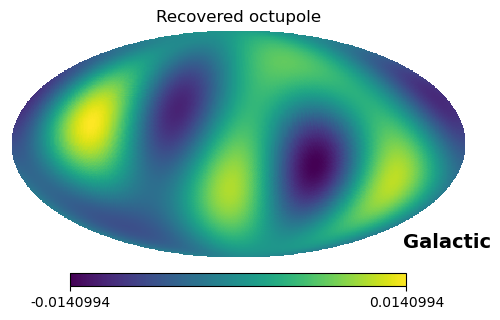

In [16]:
pars, stderr = fit_multipole(map_to_fit, octupole_templates, idx=~np.isnan(map_to_fit))
print("best-fit pars: ", pars)

# octupole scaled by the monopole
bestfit_map = multipole_map(pars[1:], NSIDE=NSIDE) / pars[0]
fig = plt.figure(figsize=(7,3))
hp.mollview(bestfit_map, coord=['C','G'], title='Recovered octupole', fig=fig)

In [17]:
amp = np.linalg.norm(pars[1:]/pars[0])
amp

0.014373932501107405

### dipole + quadrupole

Text(0.5, 0.98, 'Dipole + quadrupole templates')

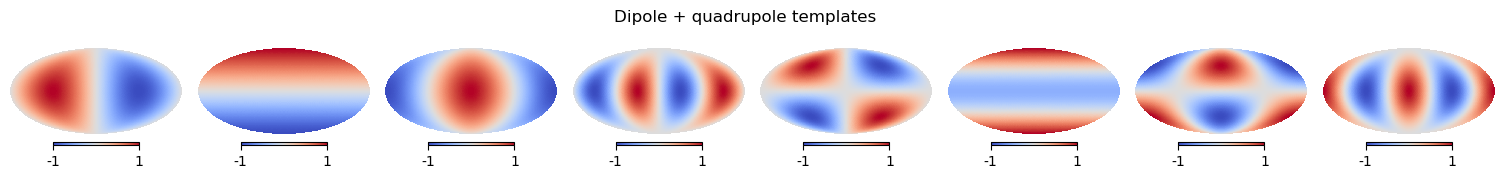

In [18]:
templates = np.concatenate([new_dipole_templates, quadrupole_templates])

fig = plt.figure(figsize=(15,1.5))
for i, template in enumerate(templates):
    hp.mollview(template, sub=(1,len(templates),i+1), title='', min=-1, max=1, cmap='coolwarm', fig=fig)
fig.suptitle('Dipole + quadrupole templates')

best-fit pars:  [ 4.00390835e+01 -2.86237304e-01 -3.16323391e-01 -4.44782316e-01
  1.83601038e-01  2.84651317e-02 -1.71176767e-01 -2.48903334e-01
  5.84422527e-02]


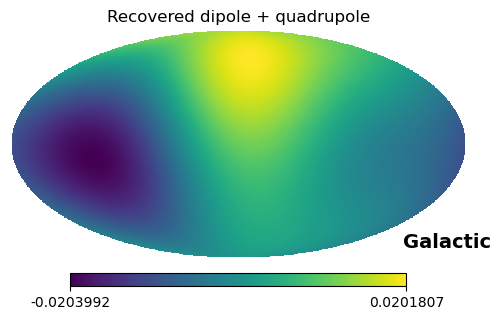

In [19]:
# fit to same map as above
pars, stderr = fit_multipole(map_to_fit, templates, idx=~np.isnan(map_to_fit))
print("best-fit pars: ", pars)

# dipole + quadrupole, scaled by the monopole
bestfit_map = (multipole_map(pars[1:4], NSIDE=NSIDE) + multipole_map(pars[4:])) / pars[0]
fig = plt.figure(figsize=(7,3))
hp.mollview(bestfit_map, coord=['C','G'], title='Recovered dipole + quadrupole', fig=fig)

In [20]:
np.linalg.norm(pars[1:4])/pars[0], np.linalg.norm(pars[4:])/pars[0]

(0.01539241765816938, 0.00897696243263175)